## Case of 8 sources and 50 receptors at 0.4 mm

### Main Modelling
We are modelling a 2-dimensional segment of bone, fixing the oscillation using a $\epsilon$ Kelvin-Voigt model of viscoelasticity, isotropic material in frequency domain (for time). For $\omega$ a frequency, the material follows:

\begin{equation}
    (-\omega^2 -  i\epsilon \omega) u  - \nabla \cdot \sigma (u) = \rho F, \text{ for } x \in \Omega
\end{equation}

\begin{equation}
\sigma(u) = C_{ijkl} \mathbf{e}_{kl}(u)
\end{equation}

where the second equation denotes the constitutive equation, with $\sigma ( \cdot)$ and $\epsilon (\cdot)$ denoting the stress and strain tensors.

We assume the only external force is given by a 5 sources, which act on the surface of the material as a *Neumann* condition, so that $F = 0 \hat{i} + 0 \hat{j}$ and:

\begin{equation}
\sigma(u) \cdot n = \mathbf{F}(\omega, x), \text{ for } x \in \Gamma_{n_i}
\end{equation}

Every force is executed sequentially, and for a frequency $\Omega$ it's defined:

In the first stage of the experimentation and discussion by (*until end of June*):
\begin{equation}
\mathbf{F}(\omega) = -exp(\frac{(f - f_0)^2}{2 \sigma^2})cos(2\pi(f-f_0)\tau_o) \hat{j}
\end{equation}

Then, after considering the input force on the time-domain problem, the force used obtained after taking fourier tranform is given at frequency $f \in [0, 2]$ by:

$$
\mathbf{F}(\omega) = \sqrt{\frac{\pi \sigma_0^2}{2}} \big[ exp \big(-\frac{1}{2} \sigma_0^2(-2\pi f- 2 \pi f_0)^2 +i t_0 (-2 \pi f- 2 \pi f_0)\big) \\
\quad +  exp \big( -\frac{1}{2} \sigma_0^2(-2 \pi f + 2 \pi f_0)^2 + it_0 (-2 \pi f + 2 \pi f_0) \big) \big]
$$

### Scheme setting

The scheme of the simulation is as follows:

- The domain, is defined by a rectangle of length = 70 mm, with width = 2mm
- At the top boundary, from left to right, we put 8 sources, where the first one is at 10 mm from the left boundary, and each one with a width of 1 mm and a distance from the center of 2 mm from one to another.
- Also there are 50 sensors at the top boundary, where the first one its located at a distance of 35mm from the right boundary, so that the distance between the last source to the first sensors is about 10 mm. Each sensor it's placed with a distance of 0.4 mm from each other.



In [ ]:
# Obtain the experimental data from .mat file
import scipy.io as sio
import numpy as np
C_mathilde = sio.loadmat('Files_mat/C_values_mathilde.mat')
# Define the constants
# The stiffness constants in [GPa] --> [g/mm(\mu sec)^2]
# are given by the mathilde .mat file of 5%
C11 = np.reshape(C_mathilde['C11'], (30,))*1E-3
C12 = np.reshape(C_mathilde['C12'], (30,))*1E-3
C13 = np.reshape(C_mathilde['C13'], (30,))*1E-3
C33 = np.reshape(C_mathilde['C33'], (30,))*1E-3
C55 = np.reshape(C_mathilde['C55'], (30,))*1E-3
d = np.reshape(C_mathilde['d'], (30,))*1E-3
C_mathilde.keys()

dict_keys(['C66', 'C12', 'C13', 'C33', 'VL_axial', '__globals__', '__header__', '__version__', 'nu', 'V_plaque', 'VT', 'C11', 'd', 'C55', 'VL_normal'])

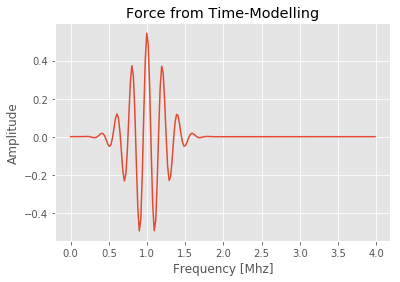

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# Comparison regarding the input force signal
# Case from Time-Modelling
# Define input parameters
times = np.arange(0, 51.2, step=1/20)
ntimes = times.shape[0]
t_0 = 5.0 # [\mu sec]
sig_time = 0.7 # [\mu sec]
def SourceTime(time, t_0, sig_time):
    factor = 1/(2*pow(sig_time,2))
    dif_time = time - t_0
    value = np.exp(-factor*pow(dif_time,2))*np.cos(2*np.pi*dif_time)
    return value

# Frequency array to consider
#freqs = np.arange(0., 2., step=20/2048)# ~ [MHz], step=20/2048
freqs = np.fft.fftfreq(times.shape[0], d=times[1]-times[0])[:205]

# Use fourier tranform over the signal
force_time = SourceTime(times, t_0, sig_time)
force_freq = np.fft.fft(force_time, n = ntimes, norm='ortho')
plt.plot(freqs, force_freq[:205].real)
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Amplitude")
plt.title("Force from Time-Modelling")
for _ in ['.pdf', '.png']:
    plt.savefig("Plots/ForceTime"+_, dpi=150, bbox_inches='tight')

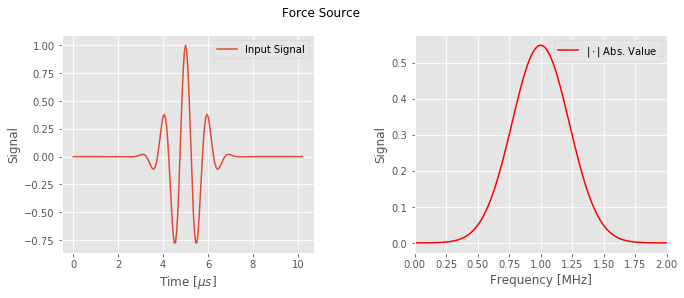

In [ ]:
# 2 columns plots of time domina force signal and its fourier representation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.subplots_adjust(left = 0.2, wspace = 0.4)
# Left-side plot
axes[0].plot(times[:205], force_time[:205])
axes[0].set_xlabel("Time $[\mu s]$")
axes[0].set_ylabel("Signal")
axes[0].legend(["Input Signal"])
#axes[0].set_xlim([0, 6])
# Right-side plot
axes[1].plot(freqs, np.abs(force_freq[:205]), "r")
#axes[1].plot(freqs, force_freq[:205].imag, "k")
#axes[1].plot(freqs, np.abs(force_freq[:205]), "-")

axes[1].set_xlabel("Frequency [MHz]")
axes[1].set_ylabel("Signal")
axes[1].legend(["$| \cdot |$ Abs. Value"])
axes[1].set_xlim([0, 2])
# Add super title
fig.suptitle("Force Source")
for _ in ['.pdf', '.png']:
    plt.savefig("Plots/ForceSource"+_, dpi=150, bbox_inches='tight')
plt.show()

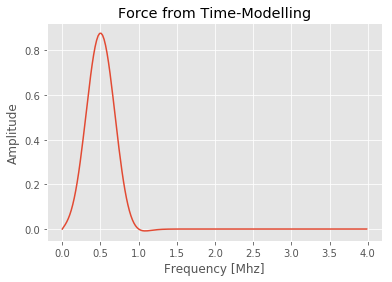

In [ ]:
# Case from Frequency-Modelling
tf_0 = 5.0 # [\mu s]
freq_0, sig_freq = 0.5, 0.7 # [Mhz], [Mhz]
def SourceFreq(freq, freq_0, sig_freq, osc_type):
    sig2, pi2 = pow(sig_freq,2), pow(np.pi,2)
    sum_freq = (freq_0 + freq)
    dif_freq = (freq_0 - freq)
    # Type of oscillation to consider
    if osc_type == "cos":
        factor = np.sqrt(np.pi*sig2/2)*np.cos(-2*np.pi*freq*freq_0)
    else:
        factor = np.sqrt(np.pi*sig2/2)*np.sin(-2*np.pi*freq*freq_0)
    # Obtaining left side and right sides
    num_ls = np.exp(-2*sig2*pi2*pow(sum_freq,2))
    num_rs = np.exp(-2*sig2*pi2*pow(dif_freq,2))
    value = factor*(num_ls+num_rs) # vertical direction
    return value
force_pure_freq = -SourceFreq(freqs, freq_0, sig_freq, "sin")
plt.plot(freqs, force_pure_freq)
plt.title("Force from Frequency-Modelling")
plt.xlabel("Frequency [Mhz]")
plt.ylabel("Amplitude")
plt.title("Force from Time-Modelling")
for _ in ['.pdf', '.png']:
    plt.savefig("Plots/ForceFreq"+_, dpi=150, bbox_inches='tight')

## Case of 8 sources and 50 receptors, with bottom as Dirichlet bdry condition

In [ ]:
from fenics import *
from mshr import *
#%matplotlib inline

# Rectangle geometry limits
zlim, ylim = 70., 2.8
# Porosity level from Mathilde data
# this data starts from 1% porosity values!
por = 11 # the porosity level is por+1
# Define domain size
size = 400
# generate domain and create mesh
domain = Rectangle(Point(0., 0.), Point(zlim, ylim))
mesh = generate_mesh(domain, size)
# Compute the minimum height diameter
print("Minimum height of element [mm]: ", mesh.hmin())
#File("Domains/2DMesh.pvd") << mesh

# Define source locations
# Using notation consistent with the 3D-case
nsous = 8
zsous, ysous = [n for n in range(10, 25, 2)], nsous*[ylim,]
# Position of sensor to obtain the force!
nsens = 50# Number of sensors separated at 0.4081 mm
zsens, ysens = np.linspace(35, 55, num=nsens), nsens*[ylim,]
# Other parameters
eps = DOLFIN_EPS
width = 0.5

# Define domain for each source
class DomSource_1(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[0]) < width + eps and
                abs(x[1] - ysous[0]) < width + eps and
                on_boundary)

class DomSource_2(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[1]) < width + eps and
                abs(x[1] - ysous[1]) < width + eps and
                on_boundary)

class DomSource_3(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[2]) < width + eps and
                abs(x[1] - ysous[2]) < width + eps and
                on_boundary)

class DomSource_4(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[3]) < width + eps and
                abs(x[1] - ysous[3]) < width + eps and
                on_boundary)

class DomSource_5(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[4]) < width + eps and
                abs(x[1] - ysous[4]) < width + eps and
                on_boundary)

class DomSource_6(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[5]) < width + eps and
                abs(x[1] - ysous[5]) < width + eps and
                on_boundary)

class DomSource_7(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[6]) < width + eps and
                abs(x[1] - ysous[6]) < width + eps and
                on_boundary)

class DomSource_8(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[7]) < width + eps and
                abs(x[1] - ysous[7]) < width + eps and
                on_boundary)



# Define source expression
class Source(Expression):
    def __init__(self, freq, freq_0,
                 sig_freq, osc,
                 degree=1):
        # initialize atributes
        self.freq, self.freq_0 = freq, freq_0
        self.sig_freq = sig_freq
        self.osc = osc

    def eval(self, values, x):
        ## Case using Fourier transform with -2*pi on the oscilation
        t_0 = 5.0 # [\mu s]
        sig2 = pow(self.sig_freq,2)
        pi2 = pow(pi,2)
        sum_freq = (self.freq_0 + self.freq)
        dif_freq = (self.freq_0 - self.freq)
        # Type of oscillation to consider
        if self.osc == "cos":
            factor = sqrt(pi*sig2/2)*cos(-2*pi*self.freq*self.freq_0)
        else:
            factor = sqrt(pi*sig2/2)*sin(-2*pi*self.freq*self.freq_0)
        # Obtaining left side and right sides
        num_ls = exp(-2*sig2*pi2*pow(sum_freq,2))
        num_rs = exp(-2*sig2*pi2*pow(dif_freq,2))
        values[0] = 0.0 # the horizontal direction
        values[1] = -factor*(num_ls+num_rs) # vertical direction

    def value_shape(self):
        return (2,)

class Attenuation(Expression):
    def __init__(self, epsilon, zlim, ylim, degree=1):
        # Define constant factor for epsilon
        self._eps = epsilon
        # Define limits of geometry for damping
        self._ylim = ylim
        self._zlim = zlim

    def eval(self, values, x):
        # If we are in the main geometry
        if x[0] > 0.0 or x[0] < self._zlim:
            values[0] = self._eps
        # If we are outside the interest zone
        else:
            if x[0] < 0.0 + DOLFIN_EPS:
                values[0] = self._eps*(1+np.abs(x[0]))
            else:
                values[0] = self._eps*(1+np.abs(x[0]-self._zlim))
        def value_shape(self):
            return (1,)
"""
from IPython.display import HTML
HTML(X3DOM().html(mesh))
"""
print("Number of Cells; {0}, of Vertice: {1}".format(mesh.num_cells(),
                                                  mesh.num_vertices()))

Minimum height of element [mm]:  0.07931657170287836
Number of Cells; 39174, of Vertice: 20193


In [ ]:
# Define mixed function space with boundary conditions
pdim = 1
V = VectorElement("CG", mesh.ufl_cell(), pdim)
V_element = MixedElement([V, V])
W = FunctionSpace(mesh, V_element)
# Define a constant function space for parameters
P = FunctionSpace(mesh, 'DG', 0)

# Mark subdomains with label 0
#subdomains = MeshFunction("size_t", mesh, mesh.topology().dim())
#subdomains.set_all(0)
# Mark boundaries with label 0
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)


# Mark boundaries (whenever necessary)
# Mark domain sources with 2
DomSource_1().mark(boundaries, 21)
DomSource_2().mark(boundaries, 22)
DomSource_3().mark(boundaries, 23)
DomSource_4().mark(boundaries, 24)
DomSource_5().mark(boundaries, 25)
DomSource_6().mark(boundaries, 26)
DomSource_7().mark(boundaries, 27)
DomSource_8().mark(boundaries, 28)

# Define new measure for boundaries
dx = dx(domain=mesh)
ds = ds(domain=mesh, subdomain_data=boundaries)

# Define boundaries over the function space
# In the variational form are defined the Neumann conditions
left_jit = "on_boundary && near(x[0], 0.)"
bc_0 = DirichletBC(W.sub(0), Constant((0.,0.)), left_jit)
bc_1 = DirichletBC(W.sub(1), Constant((0.,0.)), left_jit)

In [ ]:
# Define kronecker delta in 2D and indices
delta = Identity(2)
i,j,k,l = indices(4)

# Define strain tensor
def strain(u):
    return as_tensor(0.5*(u[i].dx(j)+u[j].dx(i)),
                    (i,j))

# Define stiffness tensor C_{i,j,k,l} transverse isotropic
def VoigtToTensor(A):
    # We use the convention, for long axis 1
    # Upper diagonal part
    A11, A13, A15 = A[0,0], A[0,1], A[0,2]
    A33, A35 = A[1,1], A[1,2]
    A55 = A[2,2]
    # Lower diagonal part (symmetric)
    A31, A51 = A13, A15
    A53 = A35

    return as_tensor([\
           [\
            [ [A11, A15], [A15, A13]] ,\
            [ [A51, A55], [A55, A53]] \
           ], \
           [
            [ [A51, A55], [A55, A53]] ,\
            [ [A31, A35], [A35, A33]] \
           ] \
                     ])

# We take the standard density
rho = d[por] # [g/cm^3] --> [g/(mm)^3]
# Define the Voigt matrix representing the tensor
# Here, the 3-axis is the z-axis, and
# 1-axis in the y-axis or x-axis by the symmetry
C_voigt = np.array([\
                   [C33[por], C13[por], 0], \
                   [C13[por], C11[por], 0], \
                   [0, 0, C55[por]]
                   ])
# Obtain the stiffness tensor
C = VoigtToTensor(C_voigt)
# Define stress tensor
def sigma(u):
    return as_tensor(C[i,j,k,l]*strain(u)[k,l], (i,j))

In [ ]:
# Define the three main blocks in variational forms
def o_block(u, v, f):
    return -rho*pow(f,2)*inner(u, v)*dx

def eps_block(u, v, f, damping):
    return damping*f*inner(u, v)*dx

def A_block(u, v):
    return inner(sigma(u), grad(v))*dx

def b_block(source, v, bdry_id):
    return dot(source, v)*ds(bdry_id)

# Frequency array to consider
freqs = np.arange(0., 2., step=20/2048)# ~ [MHz], step=20/2048
omegas = 2*pi*freqs
# Define number of frequencies
nfreq = freqs.shape[0]
# Define sensors arrays for real and imaginary parts
solR_sensors_z = np.zeros((nsens, nfreq, nsous))
solR_sensors_y = np.zeros((nsens, nfreq, nsous))
solI_sensors_z = np.zeros((nsens, nfreq, nsous))
solI_sensors_y = np.zeros((nsens, nfreq, nsous))

for ii in range(nsous):
    idx = int(ii + 21)
    count = sum(1 for _ in SubsetIterator(boundaries,idx))
    print("Facet marked as %d have %d points" % (idx, count))

# Check if the points a the left have been taken.
print("Points at boundary left(): ",
      len(bc_0.get_boundary_values()))

Facet marked as 21 have 7 points
Facet marked as 22 have 9 points
Facet marked as 23 have 7 points
Facet marked as 24 have 6 points
Facet marked as 25 have 7 points
Facet marked as 26 have 8 points
Facet marked as 27 have 6 points
Facet marked as 28 have 10 points
Points at boundary left():  66


In [ ]:
## Iterate of freq. and solution saving for a point sensor
# Define trial and test functions
(u_r, u_i) = TrialFunctions(W)
(v_r, v_i) = TestFunctions(W)

# list all boundaries
bcs = [bc_0, bc_1]

# Define name solutions for saving with File
filename = "SimMixedP"+str(por+1)+"TransIso"+str(ylim)+ \
           "M"+str(size)+"Freq.pvd"
filepvd ="Results/"+filename
vtk_u = File(filepvd)

# Define parameter for the imaginary part
epsilon = 0.5E-3 # TEST!
# Iteration over each frequency
for idx_i in range(nfreq):
    ## Define Neumann boundary condition for source
    freq, freq_0 = float(freqs[idx_i]), 0.5 # ~ 0.5 [MHz]
    # Define general variance
    sig_freq = 0.7 # sig_time ~ 0.7 [Mhz]
    exp_R = Source(freq=freq, freq_0=freq_0,
                   sig_freq=sig_freq, osc="cos",
                   degree=1)
    exp_I = Source(freq=freq, freq_0=freq_0,
                   sig_freq=sig_freq, osc="sin",
                   degree=1)
    # Interpolate source over domain
    src_R = interpolate(exp_R, W.sub(0).collapse())
    src_I = interpolate(exp_I, W.sub(1).collapse())

    # Define damping and interpolate it
    exp_att = Attenuation(epsilon=epsilon,
                          zlim=zlim, ylim=ylim,
                          degree=1)
    damping = interpolate(exp_att, P)
    # Variational forms (real and imaginary parts
    Ar_lhs = o_block(u_r,v_r,omegas[idx_i]) + \
             eps_block(u_i,v_r,omegas[idx_i],damping) + \
             A_block(u_r,v_r)
    Ai_lhs = o_block(u_i,v_i,omegas[idx_i]) - \
             eps_block(u_r,v_i,omegas[idx_i],damping) + \
             A_block(u_i,v_i)

    A = assemble(Ar_lhs + Ai_lhs)

    # Apply source sequentially
    for sous_j in range(nsous):
        # Define function-solution
        u_sol = Function(W)
        #u_rsol = Function(W.sub(0).collapse())
        #u_isol = Function(W.sub(1).collapse())
        # Compute boundary layer
        bdry_id = int(21 + sous_j)
        b_rhs = b_block(src_R, v_r, bdry_id) + \
                b_block(src_I, v_i, bdry_id)

        # Assemble of matrices
        b = assemble(b_rhs)
        # Apply boundary conditions
        [bc.apply(A,b) for bc in bcs]

        # Solve the variational problem
        solve(A, u_sol.vector(), b)
        # Assign real and imaginary parts
        (u_rsol, u_isol)  = u_sol.split(True)
        # Compute data at the sensors and save it as array
        for sens_k in range(nsens):
            # Obtain point value of solution u
            sensor_point = Point(np.array((zsens[sens_k], ysens[sens_k])))
            # Save data values at the sensor location
            solR_sensors_z[sens_k, idx_i, sous_j] = u_rsol(sensor_point)[0]
            solR_sensors_y[sens_k, idx_i, sous_j] = u_rsol(sensor_point)[1]
            solI_sensors_z[sens_k, idx_i, sous_j] = u_isol(sensor_point)[0]
            solI_sensors_y[sens_k, idx_i, sous_j] = u_isol(sensor_point)[1]

        if sous_j == 0:
            # Save vtk solution
            #vtk_u << (u_sol, float(freq_i))
            # Print some info about the solutions
            print("Value at sensor: {0}, with freq: {1:.3f} [MHz]".format(
                  u_sol(sensor_point)[1], freq))
            #print("Value rhs", np.linalg.norm(b, ord=2))


Value at sensor: -7926.814309007697, with freq: 0.000 [MHz]
Value at sensor: 2.685666550259993, with freq: 0.010 [MHz]
Value at sensor: -1.0755057412572502, with freq: 0.020 [MHz]
Value at sensor: 0.1817653066886495, with freq: 0.029 [MHz]
Value at sensor: 0.4533267274545907, with freq: 0.039 [MHz]
Value at sensor: -0.3080790544015943, with freq: 0.049 [MHz]
Value at sensor: -0.31656965269329695, with freq: 0.059 [MHz]
Value at sensor: 0.29338390550219495, with freq: 0.068 [MHz]
Value at sensor: 0.2922719458534301, with freq: 0.078 [MHz]
Value at sensor: -0.3316053611072149, with freq: 0.088 [MHz]
Value at sensor: -0.2119880540177094, with freq: 0.098 [MHz]
Value at sensor: 0.37149989109771764, with freq: 0.107 [MHz]
Value at sensor: 0.14361197440230183, with freq: 0.117 [MHz]
Value at sensor: -0.204528727589965, with freq: 0.127 [MHz]
Value at sensor: -0.2525612778807124, with freq: 0.137 [MHz]
Value at sensor: 0.05876421203586317, with freq: 0.146 [MHz]
Value at sensor: 0.30020863567

Value at sensor: 4.735362554535994e-05, with freq: 1.299 [MHz]
Value at sensor: 9.859577477602231e-05, with freq: 1.309 [MHz]
Value at sensor: 0.0003208875732699716, with freq: 1.318 [MHz]
Value at sensor: 7.991211857236009e-05, with freq: 1.328 [MHz]
Value at sensor: -0.00029095654343355877, with freq: 1.338 [MHz]
Value at sensor: -0.00022645143403799296, with freq: 1.348 [MHz]
Value at sensor: 0.00016324193180846156, with freq: 1.357 [MHz]
Value at sensor: 0.00023847258630125916, with freq: 1.367 [MHz]
Value at sensor: -0.00014471756152078987, with freq: 1.377 [MHz]
Value at sensor: -0.00016420113884076413, with freq: 1.387 [MHz]
Value at sensor: 0.00011518038517083123, with freq: 1.396 [MHz]
Value at sensor: 8.312716295401612e-05, with freq: 1.406 [MHz]
Value at sensor: -3.751900107191801e-05, with freq: 1.416 [MHz]
Value at sensor: -4.004430943182605e-05, with freq: 1.426 [MHz]
Value at sensor: -1.1735922149056984e-06, with freq: 1.436 [MHz]
Value at sensor: 1.619608026416491e-05, 

In [ ]:
import scipy.io as sio
# create dictionary with variables to save
savedic = {'zlim': zlim, 'ylim': ylim, 'nsous': nsous,
          'zsous': zsous, 'ysous': ysous, 'nsens': nsens,
          'zsens': zsens, 'ysens': ysens, 'nfreq': nfreq,
          'freqs': freqs, 'omegas': omegas,
          'solR_sensors_z': solR_sensors_z, 'solR_sensors_y': solR_sensors_y,
          'solI_sensors_z': solI_sensors_z, 'solI_sensors_y': solI_sensors_y}
filename = 'Files_mat/SimMixedP'+str(por+1)+'TransIsoW'+ \
           str(ylim)+'M'+str(size)+"eps05E-3Full"
sio.savemat(filename, savedic, appendmat=True)

## Data Processing

In [ ]:
# Cell created just for testing and recovering purposes
import scipy.io as sio
import numpy as np
saved_file = 'SimMixedP'+str(por+1)+'TransIsoW'+ \
              str(ylim)+'M'+str(size)+"eps05E-3Full"
data = sio.loadmat('Files_mat/'+saved_file+'.mat')

solR_sensors_z, solI_sensors_z = data['solR_sensors_z'], data['solI_sensors_z']
solR_sensors_y, solI_sensors_y = data['solR_sensors_y'], data['solI_sensors_y']
nsens = int(data['nsens'])
nsous = int(data['nsous'])
nfreq = int(data['nfreq'])
freqs = np.reshape(data['freqs'], (np.size(data['freqs']),))
omegas = np.reshape(data['omegas'], (np.size(data['omegas']),))
data.keys()


dict_keys(['omegas', 'zlim', 'zsous', 'nfreq', 'solI_sensors_y', 'ysens', 'nsens', 'freqs', '__header__', '__globals__', 'solR_sensors_y', 'nsous', '__version__', 'ylim', 'zsens', 'ysous', 'solR_sensors_z', 'solI_sensors_z'])

Min: -7462.347920489699, and Max: 3.4703605857187885 (example)


(-100, 100)

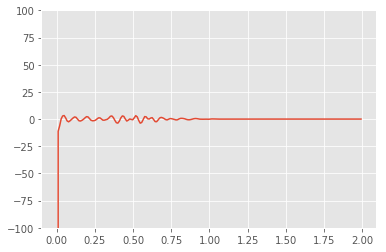

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#import numpy as np

# [sensor_id, freq_id, sous_id]
print("Min: {0}, and Max: {1} (example)".format(
      np.min(solR_sensors_y[0, :, 1]),
      np.max(solR_sensors_y[0, :, 1])))

plt.plot(freqs, solR_sensors_y[1, :, 1])
plt.ylim([-100, 100])

In [ ]:
def NormSVB(f_id, k, iFU, M):
    """
    Generate norm(f,k) = \sum_{i=0}^m |iFU[freq]|_k
    given 3d Fourier data of:  iFU(f_id) = (iFU_1 | iFU_2|...|iFU_{N_E}),
    f_id: frequency, k: wavenumber, M: Parameters to adjust mannualy

    Input: iFU 3d array
    Return: NormSVB for each k wavenumber
    """
    norm_fk = float(0) # to save to norm value

    # Iterate over the first M columns of U
    for m in range(M):
        norm_fk += np.absolute(iFU[k, f_id, m])
        #if f_id == 0 and k == 0:
        #    print('Value {0}, freq_id {1}, k {2}'.format(norm_fk,
        #                                                 f_id, k))
    return norm_fk

def dB_signal(sous_id, signal):
    """
    The input signal has dim: (nsous,nfreq)
    """
    return 20*np.log10(signal[sous_id, :])

In [ ]:
## Take just sensors separated at 0.4081 [mm]
from scipy.signal import hilbert
# Sizes of sol_signal \in N_R \times N_freq \times N_E
# Amount of wavenumber to consider
nwavenums = 256*2
# Create 3d array to store svd for each freq
Rc_z = np.zeros((nsens, nfreq, nsous), dtype=complex)
Rc_y = np.zeros((nsens, nfreq, nsous), dtype=complex)
# and iFU : the inverse fourier transform
U_z = np.zeros((nsens, nfreq, nsens), dtype=complex)
U_y = np.zeros((nsens, nfreq, nsens), dtype=complex)
iFU_z = np.zeros((nwavenums, nfreq, 15), dtype=complex)
iFU_y = np.zeros((nwavenums, nfreq, 15), dtype=complex)
sig_y = np.zeros((nsous,nfreq), dtype=float)

for freq in range(nfreq):
    # Decomposition using SVB
    #Rc_z[:,freq,:] = hilbert(solR_sensors_z[:,freq,:], axis=0)
    #Rc_y[:,freq,:] = hilbert(solR_sensors_y[:,freq,:], axis=0)
    U_z[:,freq,:], sig, V = np.linalg.svd(solR_sensors_z[:,freq,:], full_matrices=True)
    U_y[:,freq,:], sig_y[:,freq], V = np.linalg.svd(solR_sensors_y[:,freq,:], full_matrices=True)
    # Compute space fourier transform, using first axis
    iFU_z[:,freq,:] = np.fft.ifft(U_z[:,freq,0:15],
                                  n=nwavenums, axis=0, norm='ortho')
    iFU_y[:,freq,:] = np.fft.ifft(U_y[:,freq,0:15],
                                  n=nwavenums, axis=0, norm='ortho')

# Consider only the first M principal signals
M = [1, 2, 4, 6]

# Define matrix of solutions
matrix_fk_z = np.zeros((nfreq, nwavenums, len(M)))
matrix_fk_y = np.zeros((nfreq, nwavenums, len(M)))

# Obtain norm for each frequency and wavenumber
for f_id, wv_id, M_id in np.ndindex(matrix_fk_z.shape):
    matrix_fk_z[f_id, wv_id, M_id] = NormSVB(f_id, wv_id, iFU_z, M[M_id])
    matrix_fk_y[f_id, wv_id, M_id] = NormSVB(f_id, wv_id, iFU_y, M[M_id])
    if f_id == 10 and wv_id == 5:
        print("Computing for freq: {0:.2f}".format(
              omegas[f_id]))
        print(" Value of NormSVB at this stage: {0:2.3f}".format(
              matrix_fk_z[f_id, wv_id, M_id]))


Computing for freq: 0.61
 Value of NormSVB at this stage: 0.094
Computing for freq: 0.61
 Value of NormSVB at this stage: 0.158
Computing for freq: 0.61
 Value of NormSVB at this stage: 0.561
Computing for freq: 0.61
 Value of NormSVB at this stage: 0.633


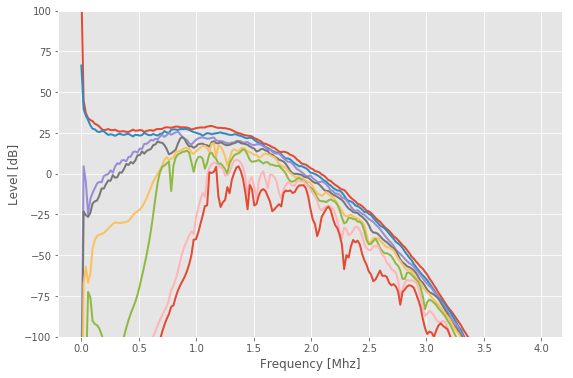

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
fig.subplots_adjust(left = 0.2, wspace = 0.4, hspace = 0.4)
# Obtaining sampled frequencies for FFT signal
freqs = np.fft.fftfreq(n = 1024, d = 1/20)[:205]
for sous_id in range(nsous):
    plt.plot(freqs, dB_signal(sous_id, sig_y[:,:]),
             linewidth=2)
plt.ylim([-100, 100])

axes.set_xlabel("Frequency [Mhz]")
axes.set_ylabel("Level [dB]")
for _ in ['.pdf', '.png']:
    filename = 'Plots/2D-FreqSimP'+str(por+1)+'W'+str(ylim)+'eKV_SV'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')

plt.show()

In [ ]:
# We load mat file of k values at different porosities
# data['por2'] array of size(n_freqs, n_modes, n_thickness)
Data_REF2D = sio.loadmat('Files_mat/k_REF2D_Datapy.mat')
# Define data of porosities, as the 4-D array
# [Por, Freq, k_val, width] --> shape [30,205,12,103]
DataPor = Data_REF2D['k_ref2D_Data']
DataFreqs = np.reshape(Data_REF2D['f'], (205,))
lim = np.max(DataFreqs)
Data_REF2D.keys()

dict_keys(['f', 'fmin', 'k2', 'kmin', '__header__', '__globals__', 'f2', 'k_ref2D_Data', 'k', 'kmax', '__version__', 'fmax'])

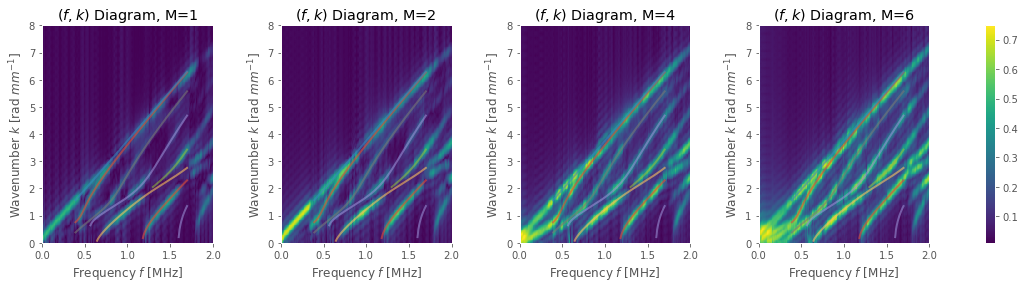

In [ ]:
# Obtain index for data arrays
index_th = lambda x: int(round(x*10-8,2)//0.5)+int(round(ylim*10-8,2)%0.5)
th = index_th(ylim)
# Define first the theoretical k_max, where 0.4 denotes
# the distance between sensors
lim = 2*np.pi/(0.4) # works using a pitch of 0.4
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22,4))
fig.subplots_adjust(left = 0.2, wspace = 0.4)
i = 0
for ax in axes.flat:
    im = ax.imshow(matrix_fk_y[: , :, i].T, extent=[0, 2, 0, lim],
                   aspect='auto')
    ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2, alpha=0.6)
    ax.grid()
    ax.set_xlabel('Frequency $f$ [MHz]')
    ax.set_ylabel('Wavenumber $k$ [rad $mm^{-1}$]')
    ax.set_xlim([0., 2.])
    ax.set_ylim([0., 8.])
    ax.set_title('$(f,k)$ Diagram, M='+str(M[i]))
    i += 1

fig.colorbar(im, ax=axes.ravel( ).tolist())
for _ in ['.pdf', '.png']:
    filename = 'Plots/2DMixedP'+str(por+1)+'TransIsoFKW'+ \
               str(ylim)+'M'+str(size)+'_y'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

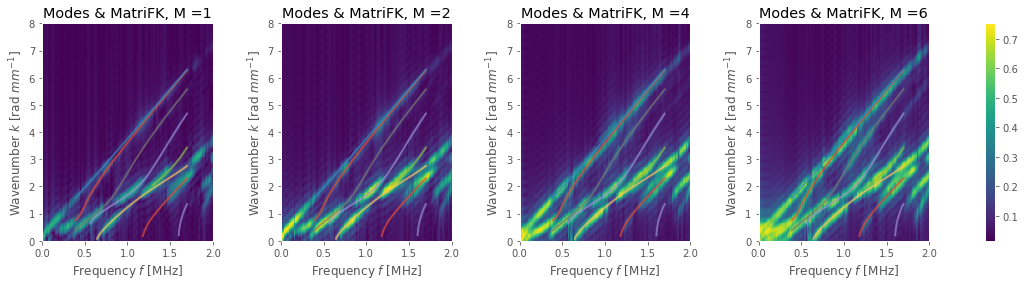

In [ ]:
# Obtain index for data arrays
index_th = lambda x: int(round(x*10-8,2)//0.5)+int(round(ylim*10-8,2)%0.5)
th = index_th(ylim)
# Define first the theoretical k_max, where 0.4 denotes
# the distance between sensors
lim = 2*np.pi/(0.4) # works using a pitch of 0.4
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22,4))
fig.subplots_adjust(left = 0.2, wspace = 0.4)
i = 0
for ax in axes.flat:
    im = ax.imshow(matrix_fk_z[: , :, i].T, extent=[0, 2, 0, lim],
                   aspect='auto')
    ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2, alpha=0.7)
    ax.grid()
    ax.set_xlabel('Frequency $f$ [MHz]')
    ax.set_ylabel('Wavenumber $k$ [rad $mm^{-1}$]')
    ax.set_xlim([0., 2.])
    ax.set_ylim([0., 8.])
    ax.set_title('$(f,k)$ Diagram, M='+str(M[i]))
    i += 1

fig.colorbar(im, ax=axes.ravel( ).tolist())
for _ in ['.png', '.pdf']:
    filename = 'Plots/2DMixedP'+str(por+1)+'TransIsoFKW'+ \
               str(ylim)+'M'+str(size)+'_z'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
"""
# Generate comparative plot using data of porosity
# Define figure with the multiple plots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(27,9))
fig.subplots_adjust(left = 0.2, wspace = 0.6, hspace = 0.4)
i, j = 0, 0
for ax in axes.flat:
    if i//5 == 0:
        im = ax.imshow(matrix_fk_z[: , :, i].T, extent=[0, 2., 0, lim],
                   aspect='auto')
        ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2)
        ax.set_title('z-direction, M ='+str(M[i]))
    else:
        im = ax.imshow(matrix_fk_y[: , :, j].T, extent=[0, 2., 0, lim],
                   aspect='auto')
        ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2)
        ax.set_title('y-direction, M ='+str(M[j]))
        j += 1

    ax.set_xlabel('Frequency $f$ [MHz]')
    ax.set_ylabel('Wavenumber $k$ [rad $mm^{-1}$]')
    ax.set_xlim([0., 2.0])
    # ylim should be equal to 2*pi/p, where p = 0.4 mm
    ax.set_ylim([0., 10.])
    i += 1

fig.colorbar(im, ax=axes.ravel().tolist())
#filename = 'Plots/2RowsVarP'+str(por+1)+ \
#           'TransIsoFKW'+str(ylim)+ \
#           'M'+str(size)+'_zy.png'
#plt.savefig(filename, dpi=150, bbox_inches='tight')
#plt.show()
"""